# Read data

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [48]:
server = 'DESKTOP-4I8KM5F'
database = 'cars_data'
driver = 'ODBC Driver 17 for SQL Server'
connection_string = f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

conn = pyodbc.connect(connection_string)

In [49]:
def get_table(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_name LIKE '%[_]%'")
    tables = cursor.fetchall()
    cursor.close()
    return [table[0] for table in tables]

In [50]:
car_tables = get_table(conn)
dfs = {}

In [51]:
for table in car_tables:
    query = f"SELECT * FROM [{table}]"
    try:
        df = pd.read_sql(query, conn)
        dfs[table] = df
        print(f"Data from table '{table}' retrieved successfully")
    
    except Exception as e:
        print(f"Error retrieving data from table '{table}': {e}")

conn.close()

Data from table 'bonbanh_inf' retrieved successfully
Data from table 'newcar_inf' retrieved successfully
Data from table 'used_Car' retrieved successfully
Data from table 'final_data' retrieved successfully


C:\Users\Admin\AppData\Local\Temp\ipykernel_17864\1449589249.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [52]:
final_data = dfs['final_data']

In [53]:
Q1 = final_data['Price'].quantile(0.25)
Q3 = final_data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_data = final_data[(final_data['Price'] >= lower_bound) & (final_data['Price'] <= upper_bound)]
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, 0 to 4712
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4392 non-null   object 
 1   Price         4392 non-null   float64
 2   Sale_Date     4392 non-null   object 
 3   Public_Year   4392 non-null   int64  
 4   Mileage       4392 non-null   float64
 5   Origin        4392 non-null   object 
 6   Body_Type     4392 non-null   object 
 7   Seats         4392 non-null   int64  
 8   City          4392 non-null   object 
 9   Year          4392 non-null   int64  
 10  Fuel_Type     4392 non-null   object 
 11  Engine        4392 non-null   int64  
 12  Manufacturer  4392 non-null   object 
 13  Price_binned  4392 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 514.7+ KB


In [54]:
Q1 = final_data['Price'].quantile(0.25)
Q3 = final_data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_data = final_data[(final_data['Price'] >= lower_bound) & (final_data['Price'] <= upper_bound)]
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4231 entries, 0 to 4712
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4231 non-null   object 
 1   Price         4231 non-null   float64
 2   Sale_Date     4231 non-null   object 
 3   Public_Year   4231 non-null   int64  
 4   Mileage       4231 non-null   float64
 5   Origin        4231 non-null   object 
 6   Body_Type     4231 non-null   object 
 7   Seats         4231 non-null   int64  
 8   City          4231 non-null   object 
 9   Year          4231 non-null   int64  
 10  Fuel_Type     4231 non-null   object 
 11  Engine        4231 non-null   int64  
 12  Manufacturer  4231 non-null   object 
 13  Price_binned  4231 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 495.8+ KB


In [55]:
final_data.drop(columns='Public_Year', inplace=True)

In [56]:
final_data['Origin'].unique()

array(['Lap rap', 'Nhap khau'], dtype=object)

# EDA (Exploratory Data Analysis)

In [57]:
final_data.describe()

,Price,Mileage,Seats,Year,Engine
count,4231.000000,4.231000e+03,4231.000000,4231.000000,4231.000000
mean,747.439376,5.201482e+04,5.593949,4.332545,1898.900969
std,322.971978,1.371933e+05,0.939595,2.600832,529.919792
min,155.000000,0.000000e+00,2.000000,0.000000,0.000000
25%,505.000000,2.600000e+04,5.000000,2.000000,1500.000000
50%,666.000000,4.800000e+04,5.000000,4.000000,2000.000000
75%,923.500000,7.000000e+04,7.000000,6.000000,2200.000000
max,1660.000000,8.000000e+06,8.000000,20.000000,6200.000000


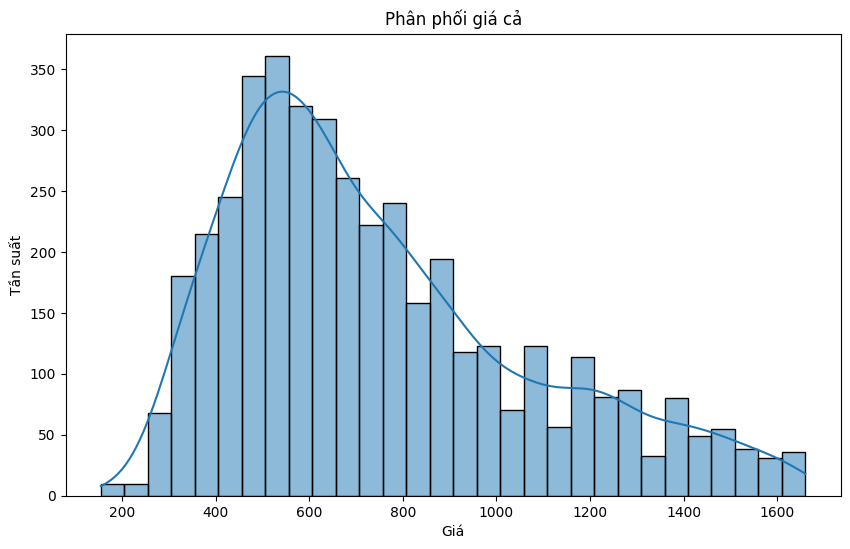

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(final_data['Price'], bins=30, kde=True)
plt.title('Phân phối giá cả')
plt.xlabel('Giá')
plt.ylabel('Tần suất')
plt.show()

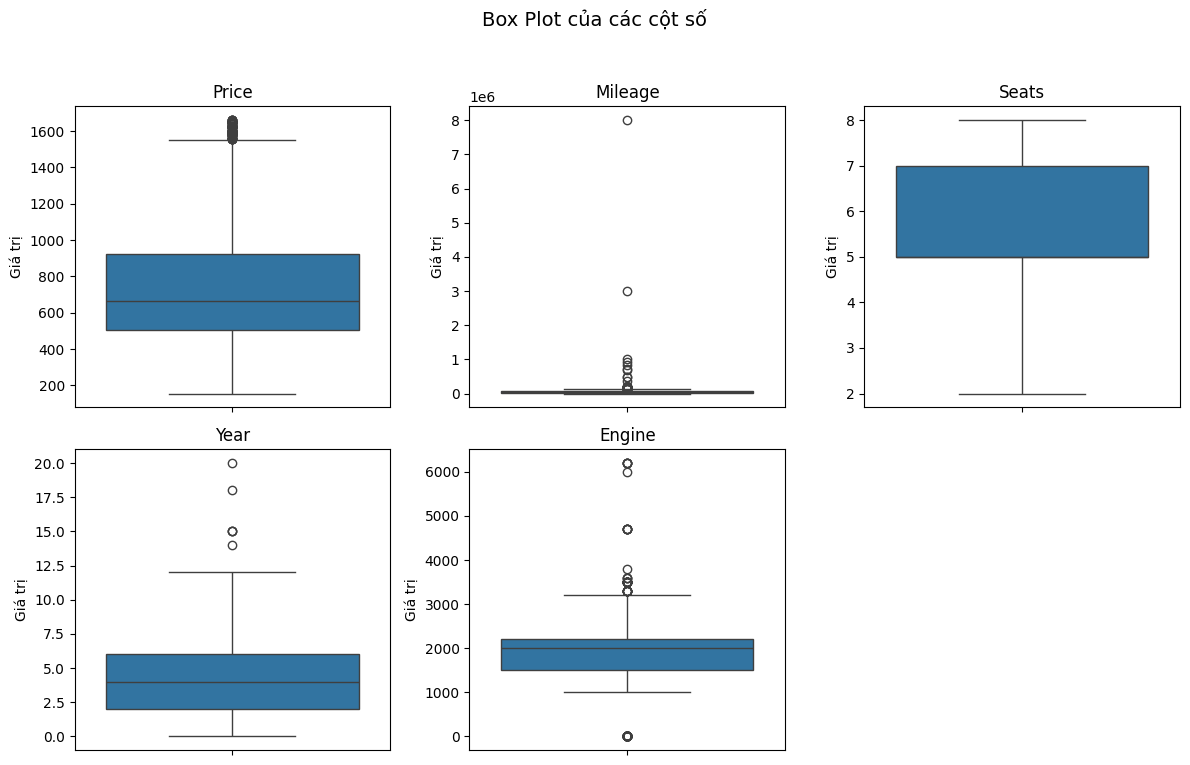

In [59]:

numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns

num_columns = len(numeric_columns)

fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(12, 4 * ((num_columns + 2) // 3)))

fig.suptitle("Box Plot của các cột số", fontsize=14)

for i, column in enumerate(numeric_columns):
    ax = axes[i // 3, i % 3] 
    sns.boxplot(y=final_data[column], ax=ax)
    ax.set_title(column)
    ax.set_ylabel("Giá trị")

for j in range(i + 1, (num_columns + 2) // 3 * 3):
    fig.delaxes(axes[j // 3, j % 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


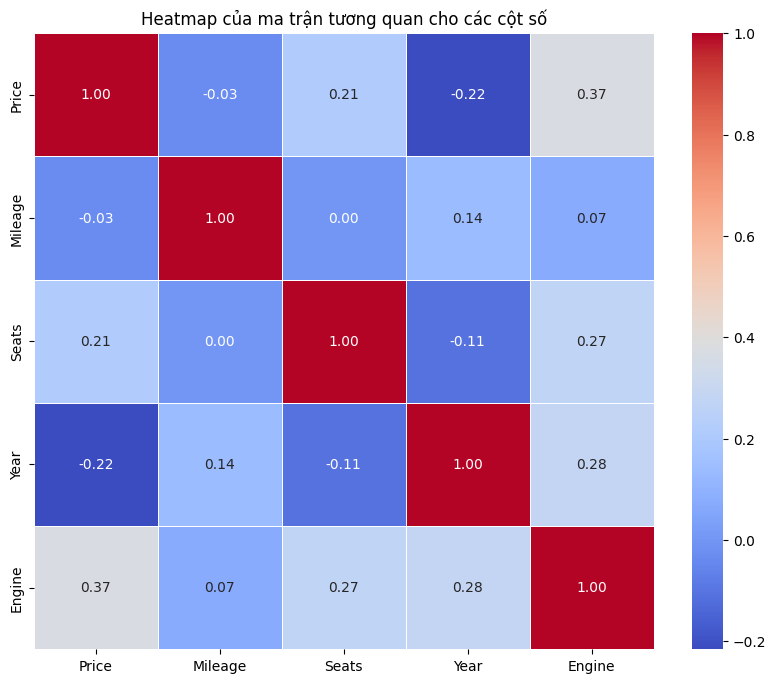

In [60]:
numeric_columns = final_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Heatmap của ma trận tương quan cho các cột số")
plt.show()

In [61]:
Q1 = final_data['Mileage'].quantile(0.25)
Q3 = final_data['Mileage'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_data = final_data[(final_data['Mileage'] >= lower_bound) & (final_data['Mileage'] <= upper_bound)]
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4190 entries, 0 to 4712
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4190 non-null   object 
 1   Price         4190 non-null   float64
 2   Sale_Date     4190 non-null   object 
 3   Mileage       4190 non-null   float64
 4   Origin        4190 non-null   object 
 5   Body_Type     4190 non-null   object 
 6   Seats         4190 non-null   int64  
 7   City          4190 non-null   object 
 8   Year          4190 non-null   int64  
 9   Fuel_Type     4190 non-null   object 
 10  Engine        4190 non-null   int64  
 11  Manufacturer  4190 non-null   object 
 12  Price_binned  4190 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 458.3+ KB


In [62]:
filtered_data= final_data[final_data['Engine'] >= 5000]
filtered_data.head()

,Name,Price,Sale_Date,Mileage,Origin,Body_Type,Seats,City,Year,Fuel_Type,Engine,Manufacturer,Price_binned
109,Bentley Flying Spur Speed,1470.0,4/11/2024,100000.0,Nhap khau,Sedan,5,Ha Noi,15,Xang,6000,Bentley,Luxury
1107,VinFast President 6.2 V8,1450.0,4/11/2024,50000.0,Lap rap,SUV,7,Ha Noi,3,Xang,6200,VinFast,Luxury
1179,VinFast President 6.2 V8,1295.0,4/11/2024,77000.0,Lap rap,SUV,7,Ha Noi,3,Xang,6200,VinFast,Luxury
1185,VinFast President 6.2 V8,1430.0,4/11/2024,57000.0,Lap rap,SUV,7,Ha Noi,3,Xang,6200,VinFast,Luxury
1311,VinFast President 6.2 V8,1290.0,4/11/2024,70000.0,Lap rap,SUV,7,Ha Noi,3,Xang,6200,VinFast,Luxury


In [63]:
Q1 = final_data['Engine'].quantile(0.25)
Q3 = final_data['Engine'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_data = final_data[(final_data['Engine'] >= lower_bound) & (final_data['Engine'] <= upper_bound)]
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4071 entries, 0 to 4712
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4071 non-null   object 
 1   Price         4071 non-null   float64
 2   Sale_Date     4071 non-null   object 
 3   Mileage       4071 non-null   float64
 4   Origin        4071 non-null   object 
 5   Body_Type     4071 non-null   object 
 6   Seats         4071 non-null   int64  
 7   City          4071 non-null   object 
 8   Year          4071 non-null   int64  
 9   Fuel_Type     4071 non-null   object 
 10  Engine        4071 non-null   int64  
 11  Manufacturer  4071 non-null   object 
 12  Price_binned  4071 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 445.3+ KB


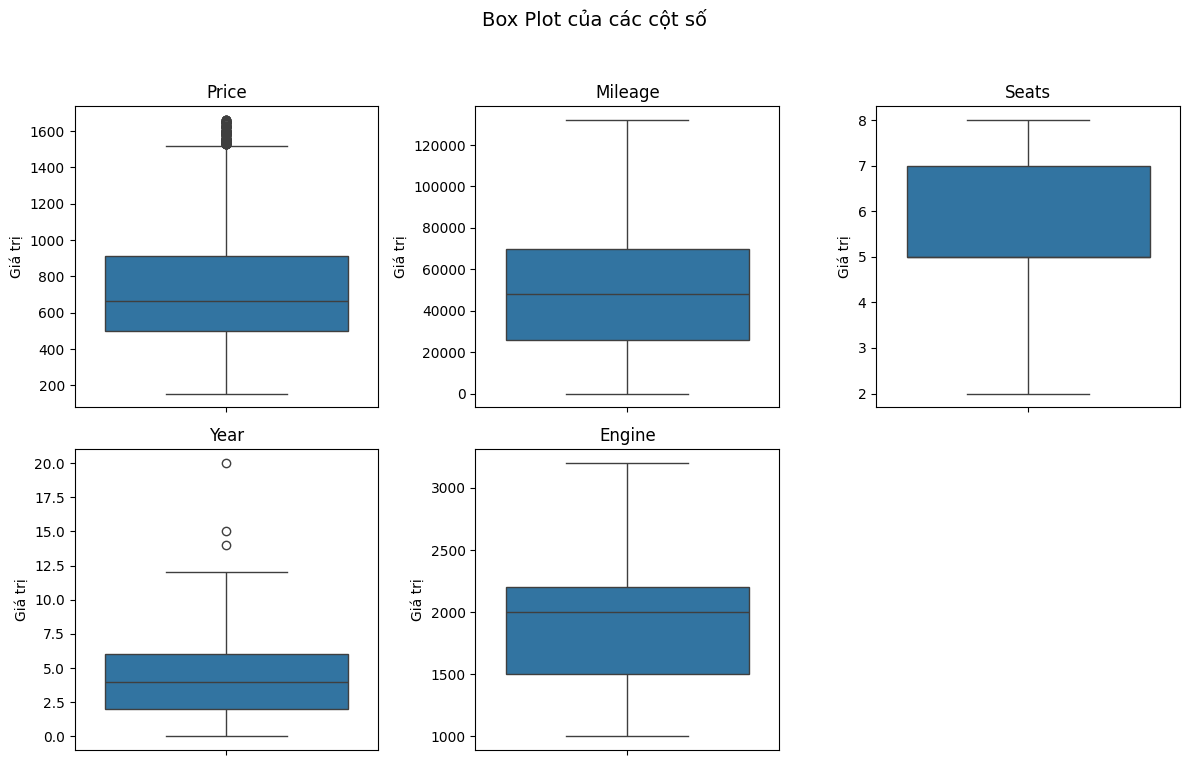

In [64]:
numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns

num_columns = len(numeric_columns)

fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(12, 4 * ((num_columns + 2) // 3)))

fig.suptitle("Box Plot của các cột số", fontsize=14)

for i, column in enumerate(numeric_columns):
    ax = axes[i // 3, i % 3] 
    sns.boxplot(y=final_data[column], ax=ax)
    ax.set_title(column)
    ax.set_ylabel("Giá trị")

for j in range(i + 1, (num_columns + 2) // 3 * 3):
    fig.delaxes(axes[j // 3, j % 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


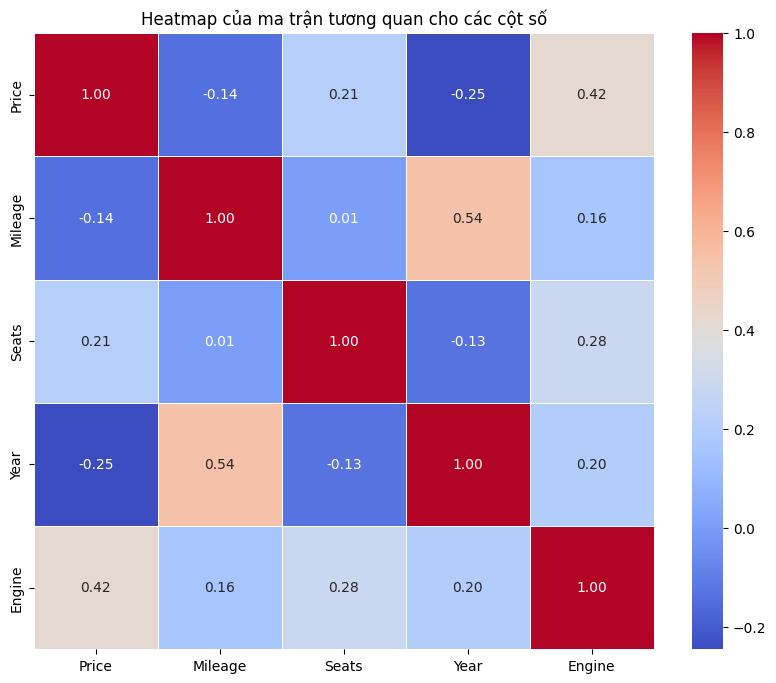

In [65]:
numeric_columns = final_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Heatmap của ma trận tương quan cho các cột số")
plt.show()

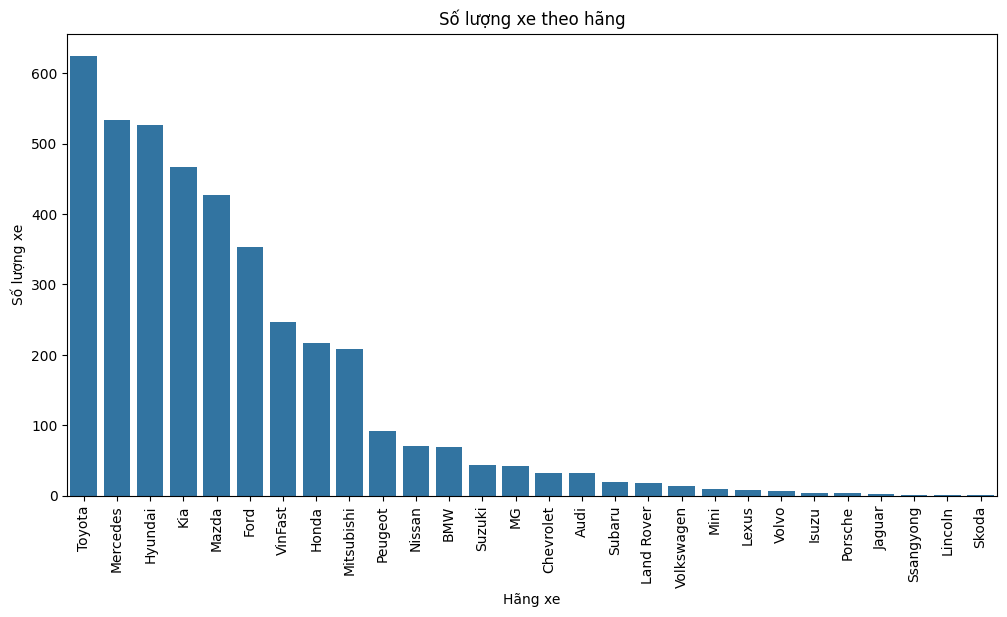

In [66]:
brand_counts = final_data['Manufacturer'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title("Số lượng xe theo hãng")
plt.xlabel("Hãng xe")
plt.ylabel("Số lượng xe")
plt.xticks(rotation=90)  # Xoay tên các hãng để dễ đọc
plt.show()

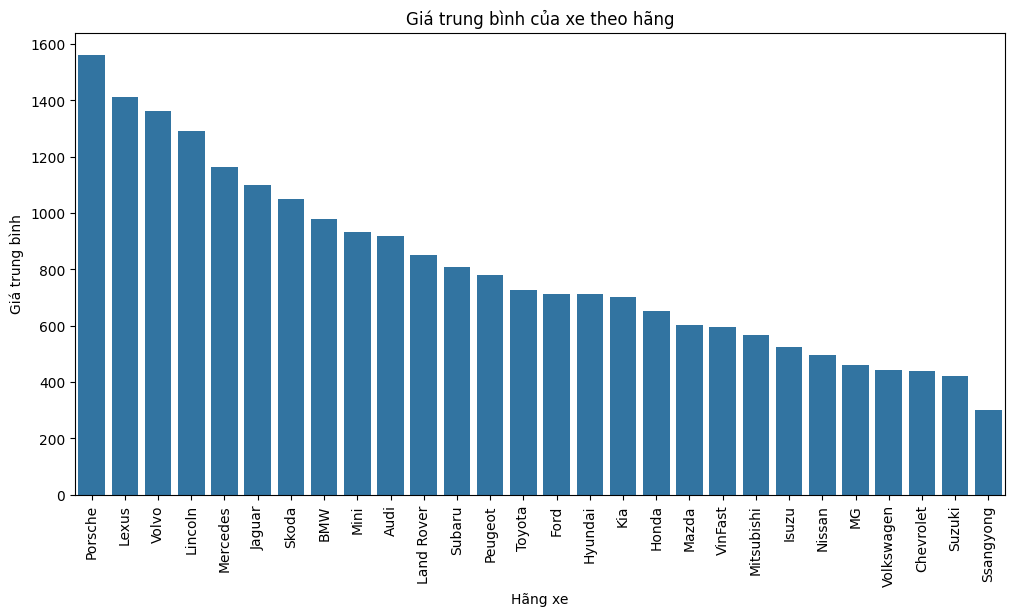

In [67]:
brand_avg_price = final_data.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values)
plt.title("Giá trung bình của xe theo hãng")
plt.xlabel("Hãng xe")
plt.ylabel("Giá trung bình")
plt.xticks(rotation=90)
plt.show()

# Visualization

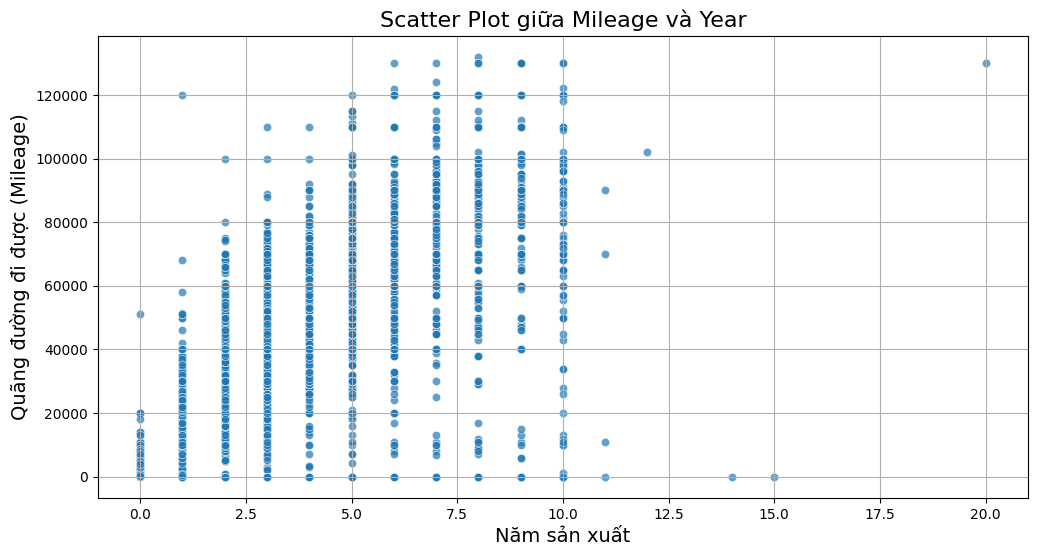

In [68]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=final_data, x='Year', y='Mileage', alpha=0.7)

plt.title('Scatter Plot giữa Mileage và Year', fontsize=16)
plt.xlabel('Năm sản xuất', fontsize=14)
plt.ylabel('Quãng đường đi được (Mileage)', fontsize=14)
plt.grid(True)
plt.show()

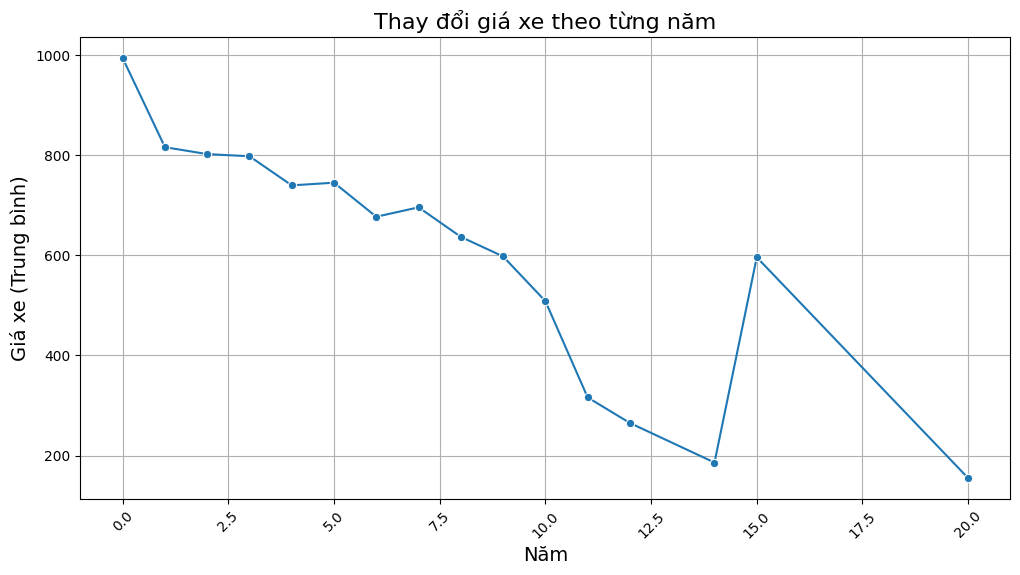

In [69]:
price_by_year = final_data.groupby('Year')['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=price_by_year, x='Year', y='Price', marker='o')
plt.title("Thay đổi giá xe theo từng năm", fontsize=16)
plt.xlabel("Năm", fontsize=14)
plt.ylabel("Giá xe (Trung bình)", fontsize=14)
plt.xticks(rotation=45)
plt.grid()
plt.show()

               City  Average_Price
0   Ba Ria Vung Tau     365.000000
1          Bac Ninh     186.000000
2        Binh Duong     382.500000
3           Dak Lak     445.000000
4           Gia Lai     425.000000
5            Ha Noi     744.336076
6         Hai Duong     430.000000
7         Hai Phong     641.000000
8           Long An     790.000000
9           Nghe An     621.500000
10        Ninh Binh     309.500000
11       Quang Ninh     491.000000
12           TP HCM     776.781250


C:\Users\Admin\AppData\Local\Temp\ipykernel_17864\2103653322.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_price_by_city, x='City', y='Average_Price', palette='viridis')


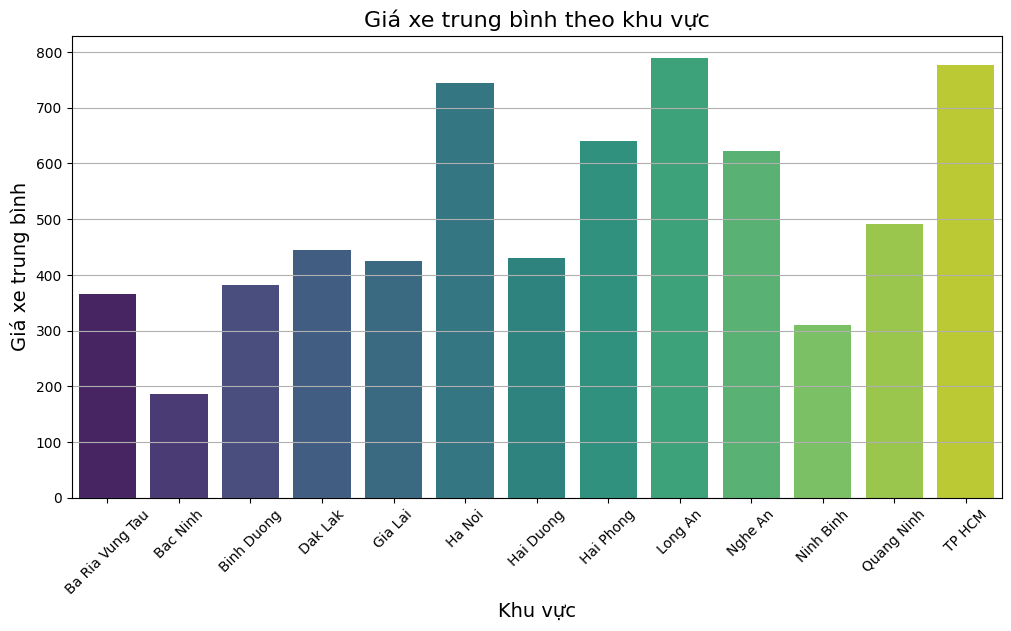

In [70]:
average_price_by_city = final_data.groupby('City')['Price'].mean().reset_index()

average_price_by_city.columns = ['City', 'Average_Price']

print(average_price_by_city)
plt.figure(figsize=(12, 6))
sns.barplot(data=average_price_by_city, x='City', y='Average_Price', palette='viridis')

plt.title('Giá xe trung bình theo khu vực', fontsize=16)
plt.xlabel('Khu vực', fontsize=14)
plt.ylabel('Giá xe trung bình', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [71]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

final_data['Mileage'] = min_max_scaling(final_data['Mileage'])
final_data['Engine'] = min_max_scaling(final_data['Engine'])
final_data['Price'] = min_max_scaling(final_data['Price'])
final_data['Seats'] = min_max_scaling(final_data['Seats'])
final_data['Year'] = min_max_scaling(final_data['Year'])
final_data.describe()

,Price,Mileage,Seats,Year,Engine
count,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000
mean,0.390622,0.360654,0.598706,0.215782,0.410269
std,0.212139,0.221905,0.155724,0.126183,0.185790
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.229236,0.196970,0.500000,0.100000,0.227273
50%,0.338870,0.363636,0.500000,0.200000,0.454545
75%,0.501661,0.530303,0.833333,0.300000,0.545455
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
final_data.drop(columns='Sale_Date', inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4071 entries, 0 to 4712
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4071 non-null   object 
 1   Price         4071 non-null   float64
 2   Mileage       4071 non-null   float64
 3   Origin        4071 non-null   object 
 4   Body_Type     4071 non-null   object 
 5   Seats         4071 non-null   float64
 6   City          4071 non-null   object 
 7   Year          4071 non-null   float64
 8   Fuel_Type     4071 non-null   object 
 9   Engine        4071 non-null   float64
 10  Manufacturer  4071 non-null   object 
 11  Price_binned  4071 non-null   object 
dtypes: float64(5), object(7)
memory usage: 413.5+ KB


In [73]:
van_prices = final_data[final_data['Body_Type'] == 'Van']['Price']
other_prices = final_data[final_data['Body_Type'] != 'Van']['Price']

t_stat, p_value = ttest_ind(van_prices, other_prices, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 12.795212696039908
P-value: 2.303259246963402e-26


In [74]:
correlation, p_value = pearsonr(final_data['Seats'], final_data['Price'])

print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

Pearson correlation coefficient: 0.21190841025085588
P-value: 1.4906293719631314e-42


In [75]:
groups = [group['Price'].values for name, group in final_data.groupby('Price_binned')]

f_stat, p_value = f_oneway(*groups)

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 13519.297993254075
P-value: 0.0


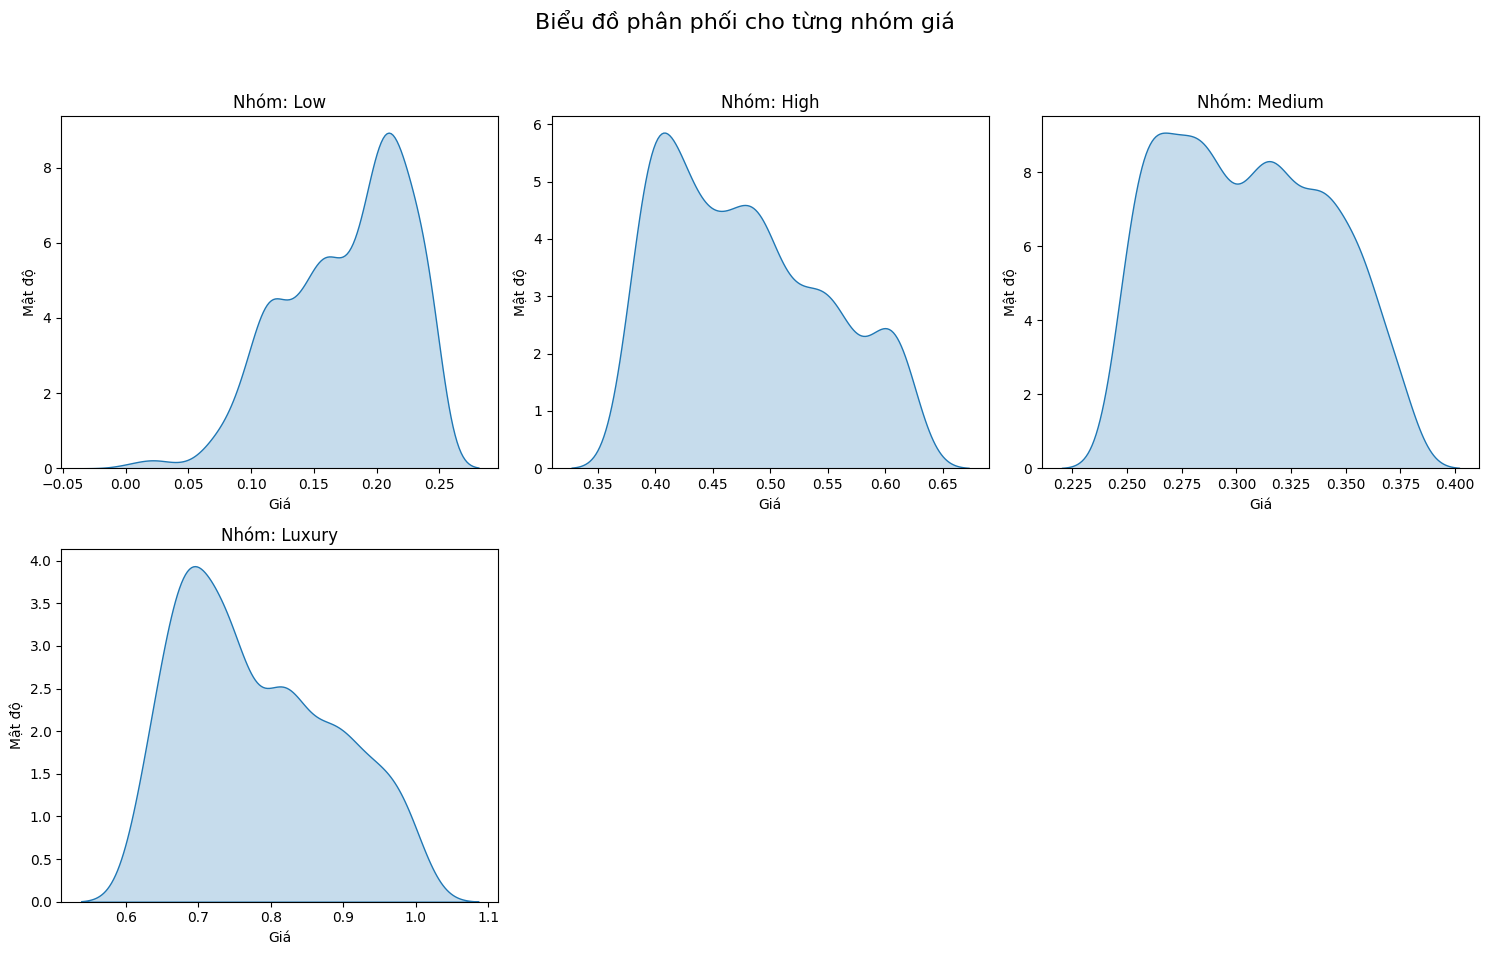

In [76]:
price_groups = final_data['Price_binned'].unique()

num_groups = len(price_groups)
fig, axes = plt.subplots(nrows=(num_groups + 2) // 3, ncols=3, figsize=(15, 5 * ((num_groups + 2) // 3)))
fig.suptitle("Biểu đồ phân phối cho từng nhóm giá", fontsize=16)

for i, group in enumerate(price_groups):
    ax = axes[i // 3, i % 3]
    sns.kdeplot(final_data[final_data['Price_binned'] == group]['Price'], ax=ax, fill=True)
    ax.set_title(f'Nhóm: {group}')
    ax.set_xlabel('Giá')
    ax.set_ylabel('Mật độ')

for j in range(i + 1, (num_groups + 2) // 3 * 3):
    fig.delaxes(axes[j // 3, j % 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [77]:
groups = [group['Price'].values for name, group in final_data.groupby('Fuel_Type')]

f_stat, p_value = f_oneway(*groups)

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 90.20383255540185
P-value: 4.6642614629965435e-39


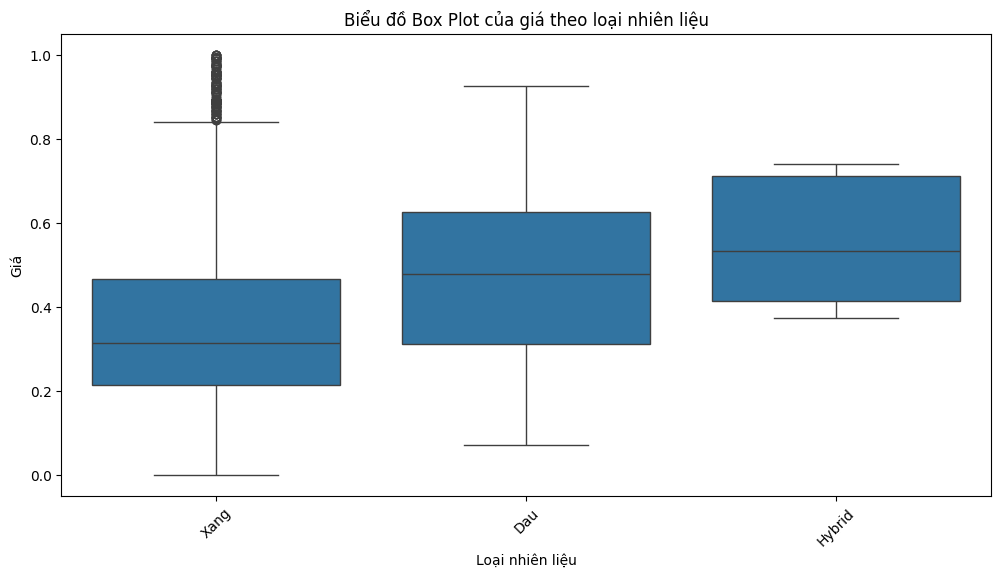

In [78]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fuel_Type', y='Price', data=final_data)
plt.title("Biểu đồ Box Plot của giá theo loại nhiên liệu")
plt.xlabel("Loại nhiên liệu")
plt.ylabel("Giá")
plt.xticks(rotation=45)
plt.show()

# --

In [79]:
final_data = final_data[final_data['Body_Type'] != 'Van']

In [80]:
final_data_encoded = pd.get_dummies(final_data, columns=['Origin', 'Body_Type', 'City', 'Fuel_Type', 'Manufacturer', 'Price_binned'])

In [81]:
final_data_encoded.describe()

,Price,Mileage,Seats,Year,Engine
count,3922.000000,3922.000000,3922.000000,3922.00000,3922.000000
mean,0.383238,0.360731,0.589963,0.21758,0.405782
std,0.209495,0.220391,0.149154,0.12647,0.187004
min,0.000000,0.000000,0.333333,0.00000,0.000000
25%,0.226080,0.196970,0.500000,0.10000,0.227273
50%,0.328904,0.363636,0.500000,0.20000,0.454545
75%,0.494352,0.530303,0.833333,0.30000,0.454545
max,1.000000,1.000000,1.000000,1.00000,1.000000


In [82]:
final_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922 entries, 0 to 4712
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     3922 non-null   object 
 1   Price                    3922 non-null   float64
 2   Mileage                  3922 non-null   float64
 3   Seats                    3922 non-null   float64
 4   Year                     3922 non-null   float64
 5   Engine                   3922 non-null   float64
 6   Origin_Lap rap           3922 non-null   bool   
 7   Origin_Nhap khau         3922 non-null   bool   
 8   Body_Type_Ban tai        3922 non-null   bool   
 9   Body_Type_Convertible    3922 non-null   bool   
 10  Body_Type_Coupe          3922 non-null   bool   
 11  Body_Type_Crossover      3922 non-null   bool   
 12  Body_Type_Hatchback      3922 non-null   bool   
 13  Body_Type_SUV            3922 non-null   bool   
 14  Body_Type_Sedan          3922

In [83]:
bool_columns = final_data_encoded.select_dtypes(include=['bool']).columns
final_data_encoded[bool_columns] = final_data_encoded[bool_columns].astype(int)
final_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922 entries, 0 to 4712
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     3922 non-null   object 
 1   Price                    3922 non-null   float64
 2   Mileage                  3922 non-null   float64
 3   Seats                    3922 non-null   float64
 4   Year                     3922 non-null   float64
 5   Engine                   3922 non-null   float64
 6   Origin_Lap rap           3922 non-null   int64  
 7   Origin_Nhap khau         3922 non-null   int64  
 8   Body_Type_Ban tai        3922 non-null   int64  
 9   Body_Type_Convertible    3922 non-null   int64  
 10  Body_Type_Coupe          3922 non-null   int64  
 11  Body_Type_Crossover      3922 non-null   int64  
 12  Body_Type_Hatchback      3922 non-null   int64  
 13  Body_Type_SUV            3922 non-null   int64  
 14  Body_Type_Sedan          3922

# Linear regression

In [84]:
X = final_data_encoded.drop(columns=['Price', 'Name'])
y = final_data_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 7.465007910690918e+19
R^2: -1.7752039026475385e+21


# Robust regression

In [85]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor()
model = HuberRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE (Huber Regressor): {mse}')
print(f'R^2 (Huber Regressor): {r2}')

MSE (Huber Regressor): 0.002757178910744678
R^2 (Huber Regressor): 0.9344333613412282


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [86]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, R^2: {r2:.4f}")

Random Forest - MSE: 0.00, R^2: 0.9675
Gradient Boosting - MSE: 0.00, R^2: 0.9426
XGBoost - MSE: 0.00, R^2: 0.9683


In [87]:
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, X, y):
    mse_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R²: {np.mean(r2_scores)}")

from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, random_state=42)
print("\nGradient Boosting:")
evaluate_model(gb_model, X, y)

from xgboost import XGBRegressor
xgb_model = XGBRegressor(learning_rate=0.1, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)
print("\nXGBoost:")
evaluate_model(xgb_model, X, y)


Gradient Boosting:
Mean MSE: 0.0024854267014330095
Mean R²: 0.9431658612481957

XGBoost:
Mean MSE: 0.0024362193533987086
Mean R²: 0.9442500361857686


In [88]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=10, random_state=42)
print("Random Forest:")
evaluate_model(rf_model, X, y)

Random Forest:
Mean MSE: 0.0014479451077219273
Mean R²: 0.9668621450601741


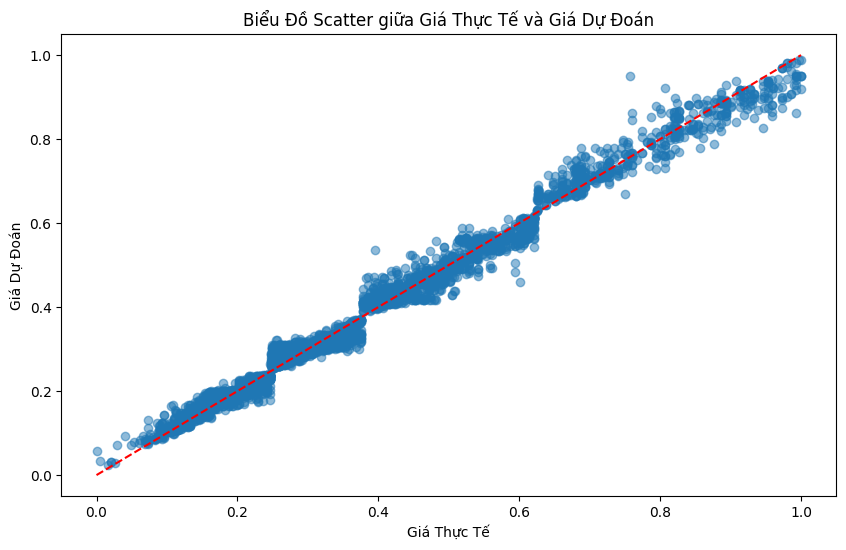

In [89]:
rf_model.fit(X, y)

y_pred = rf_model.predict(X)

errors = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.title("Biểu Đồ Scatter giữa Giá Thực Tế và Giá Dự Đoán")
plt.xlabel("Giá Thực Tế")
plt.ylabel("Giá Dự Đoán")
plt.show()

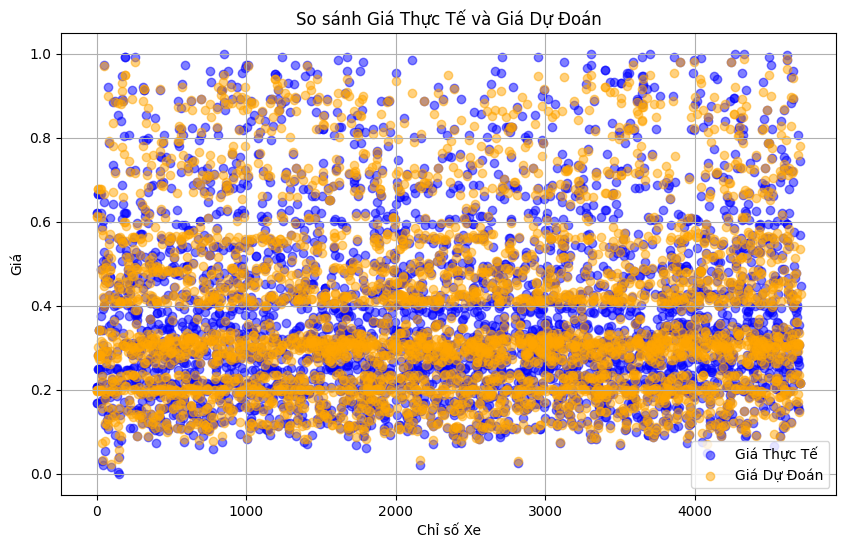

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(y.index, y, color='blue', alpha=0.5, label='Giá Thực Tế')

plt.scatter(y.index, y_pred, color='orange', alpha=0.5, label='Giá Dự Đoán')

plt.title("So sánh Giá Thực Tế và Giá Dự Đoán")
plt.xlabel("Chỉ số Xe")
plt.ylabel("Giá")
plt.legend()
plt.grid()
plt.show()
